# Seguro médico

## Objetivo

Analizar los datos de un dataset para predecir el costo de un seguro médico.

## Ejecución

### Imports

In [194]:
import sys;
assert sys.version_info >= (3, 5);
import sklearn;
assert sklearn.__version__ >= "0.20";
import numpy as np;
import math;
import os;
import matplotlib as mpl;
import matplotlib.pyplot as plt;
import pandas as pd;
import seaborn as sns;
from scipy import stats;
from scipy.stats import norm;
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

### Datos

#### Carga de datos

In [195]:
# dataset from https://www.kaggle.com/datasets/mirichoi0218/insurance
df = pd.read_csv(filepath_or_buffer="dataset/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


#### Exploración de datos

Esta primera aproximación nos permite ver que tenemos 7 columnas de las cuales 3 son categoricas y 4 son numericas. La columna `charges` es la que queremos predecir. Además, podemos ver que no tenemos valores nulos.

In [196]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Con estos datos vemos que las columnas `charges` y `children` se desplazan un poco de la media y además son valores muy distintos, tendremos que normalizar de alguna manera los datos, para las columnas categoricas no se muestran datos pero tendremos que crearlos pasando las columnas a numericas o con el one hot encoding.

In [197]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Mirando los histogramas me interesan las columnas `bmi` y `children` ya que, una tiene distribución casi normal y la otra tiene una distribución que se parece a una exponencial. Además `age` tiene unos valores un poco raros cerca de las decadas, por lo que a lo mejor lo convierto en una columna categorica.

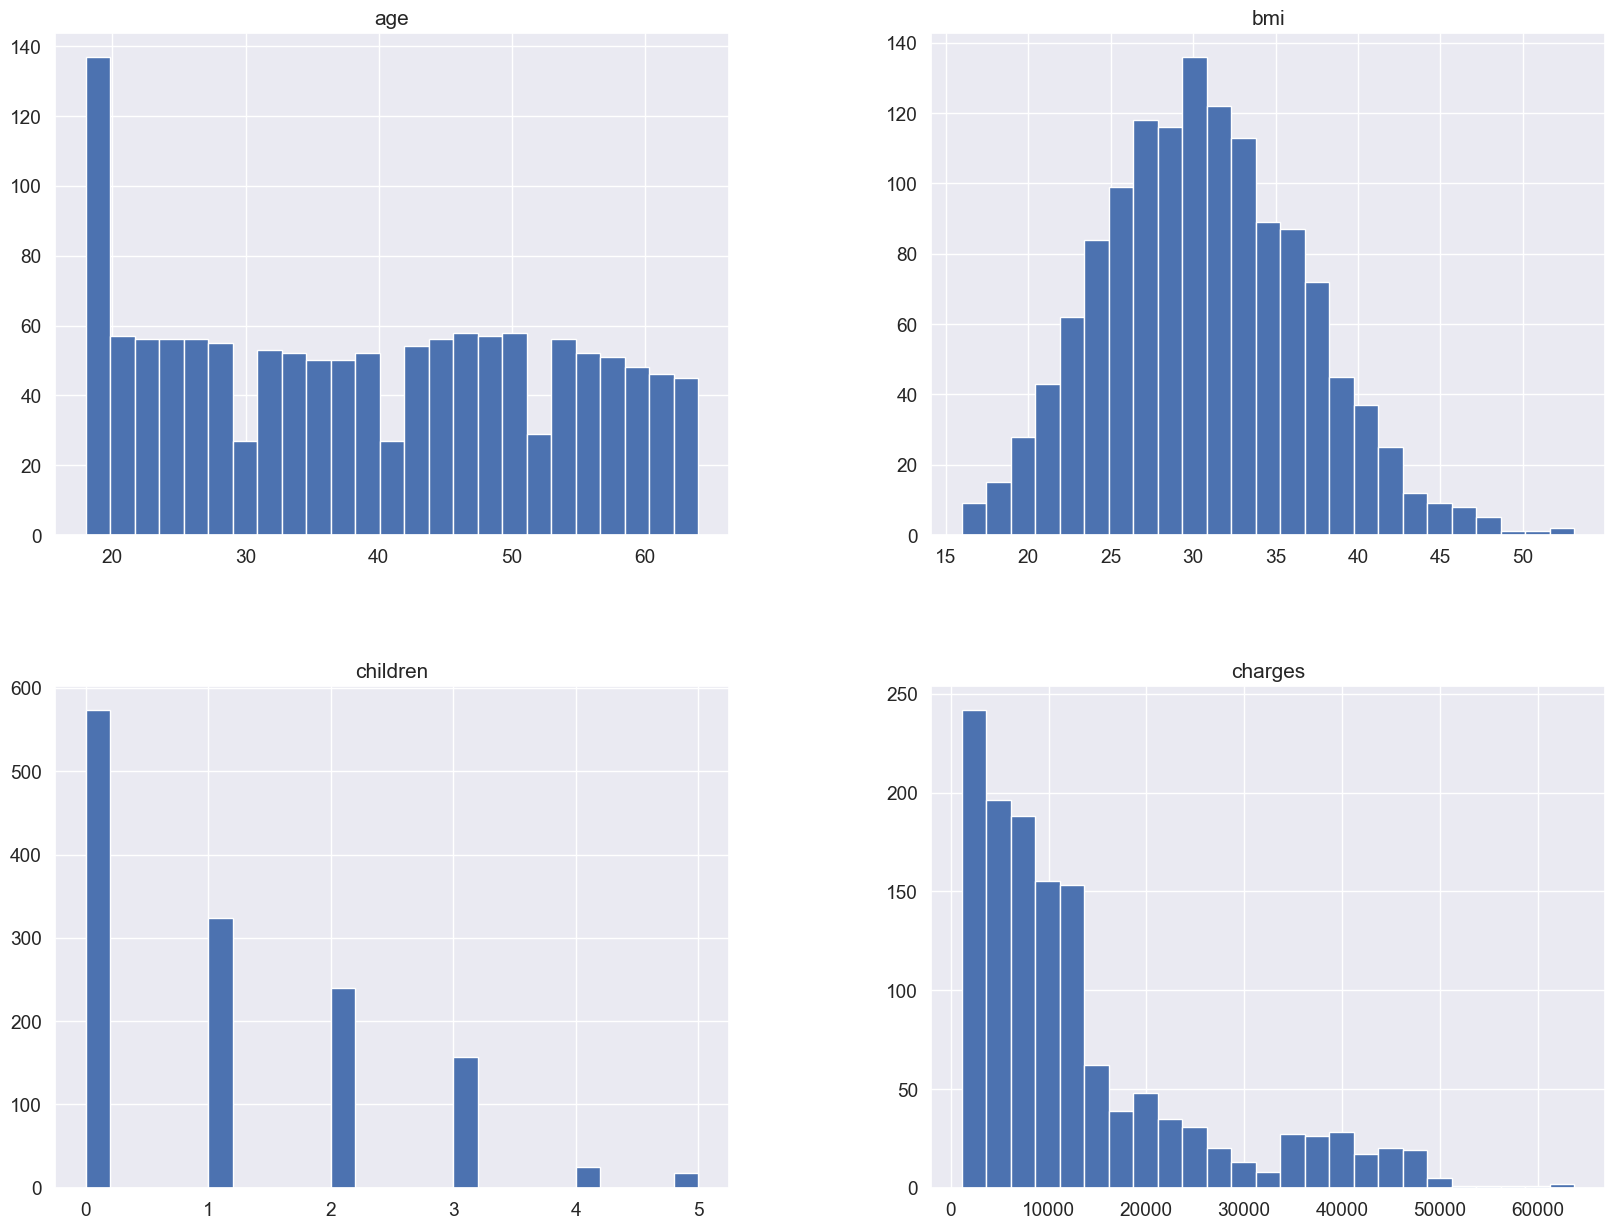

In [198]:
'''categoria = pd.cut(
    df["age"].astype(int),
    bins=[17,29,31,39,41,42,51,53,64],
    labels=['0', '1', '2','3','4','5','6','7'], 
)
df["age_group"] = categoria.astype(int)
'''
df.hist(bins=25, figsize=(20,15))

plt.show()

#### Creando datos númericos

Cambiamos smoker y sex a un valor binario 1 o 0 

In [199]:

df.smoker = df.smoker.map({'yes': 1, 'no': 0})
df.sex = df.sex.map({'female': 1, 'male': 0})
# count the smokers and non-smokers
print(df.smoker.value_counts())
print(df.sex.value_counts())


0    1064
1     274
Name: smoker, dtype: int64
0    676
1    662
Name: sex, dtype: int64


Para la columna `region` usaremos el one hot encoding

In [200]:
encoder = OneHotEncoder(sparse=False)
region_1_hot = encoder.fit_transform(df[['region']])
df=df.join(pd.DataFrame(region_1_hot, columns=[cat for cat in encoder.categories_[0]]))
df.head()


c:\Users\brais.fernandezvazqu\Miniconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,age,sex,bmi,children,smoker,region,charges,northeast,northwest,southeast,southwest
0,19,1,27.900,0,1,southwest,16884.92400,0.0,0.0,0.0,1.0
1,18,0,33.770,1,0,southeast,1725.55230,0.0,0.0,1.0,0.0
2,28,0,33.000,3,0,southeast,4449.46200,0.0,0.0,1.0,0.0
3,33,0,22.705,0,0,northwest,21984.47061,0.0,1.0,0.0,0.0
4,32,0,28.880,0,0,northwest,3866.85520,0.0,1.0,0.0,0.0


#### Correlaciones

Con los datos categoricos pasados a numericos podemos observar correlaciones que en un principio no podíamos.

In [201]:
corrmat = df.corr()

C:\Users\brais.fernandezvazqu\AppData\Local\Temp\ipykernel_12264\2179290573.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = df.corr()


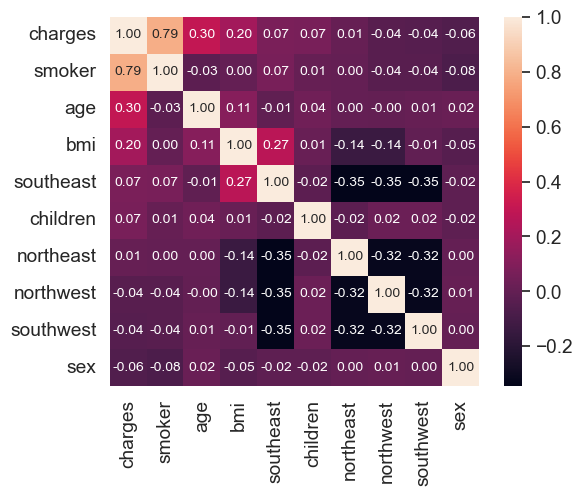

In [202]:
k = 20 #number of variables for heatmap
cols = corrmat.nlargest(k, 'charges')['charges'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Creo que se pueden crear nuevas columnas fusionando smoker con otras a ver si se puede mejorar el modelo.

In [203]:
df["smoker_fit"] =  df["bmi"].astype(int)*df["smoker"].astype(int)
df["smoker_age"] =  df["smoker"].astype(int)/df["age"].astype(int)
df["southeast_fit"] =  df["southeast"].astype(int)/df["bmi"].astype(int)

C:\Users\brais.fernandezvazqu\AppData\Local\Temp\ipykernel_12264\2912846297.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = df.corr()


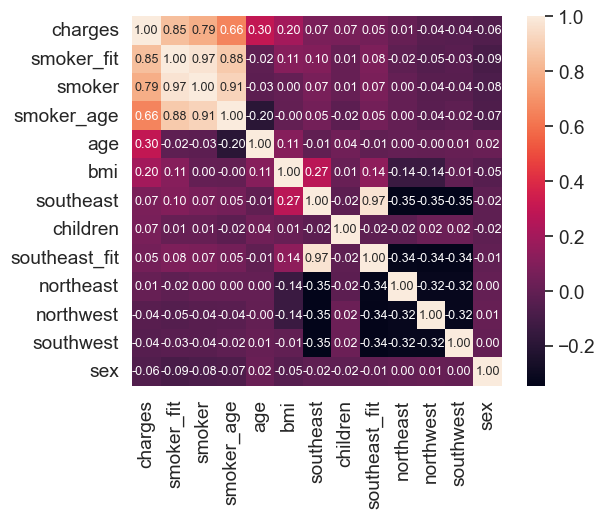

In [204]:
corrmat = df.corr()
cols = corrmat.nlargest(k, 'charges')['charges'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 9}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

<AxesSubplot: xlabel='age', ylabel='smoker_fit'>

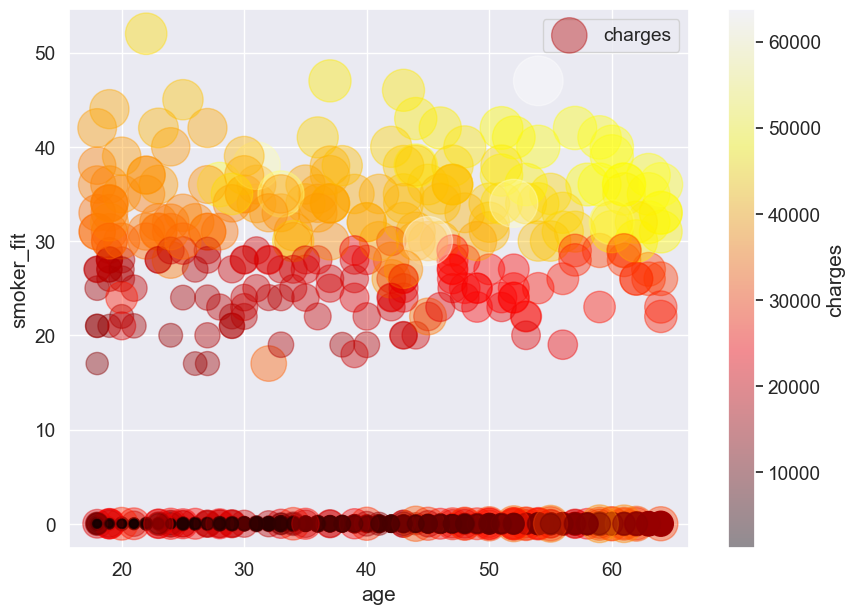

In [205]:
df.plot(kind="scatter", 
             x="age",
             y="smoker_fit", 
             alpha=0.4,
             s=df["charges"]/50, 
             label="charges", 
             figsize=(10,7),
             c="charges", 
             cmap=plt.get_cmap("hot"), 
             colorbar=True,
             sharex=False)

<AxesSubplot: xlabel='bmi', ylabel='smoker_fit'>

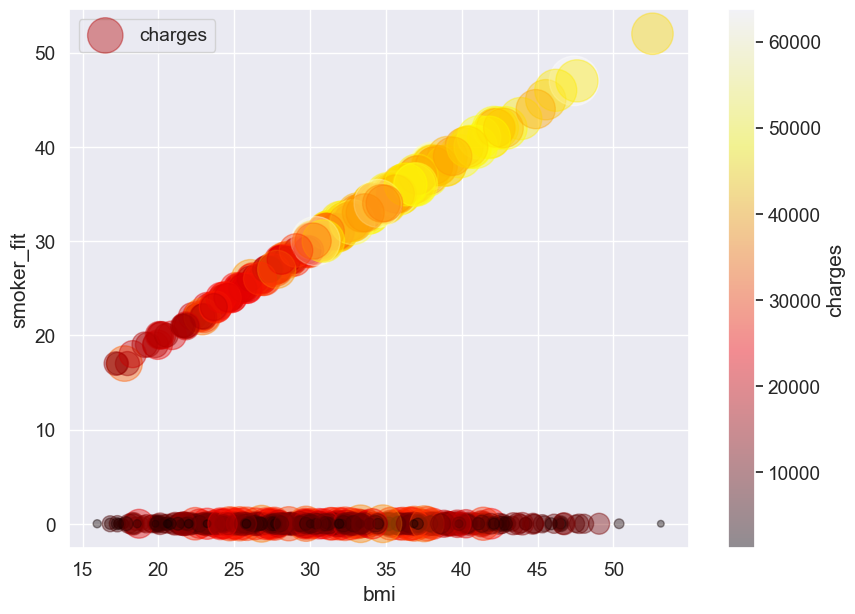

In [206]:
df.plot(kind="scatter", 
             x="bmi",
             y="smoker_fit", 
             alpha=0.4,
             s=df["charges"]/50, 
             label="charges", 
             figsize=(10,7),
             c="charges", 
             cmap=plt.get_cmap("hot"), 
             colorbar=True,
             sharex=False)

<AxesSubplot: xlabel='bmi', ylabel='smoker_age'>

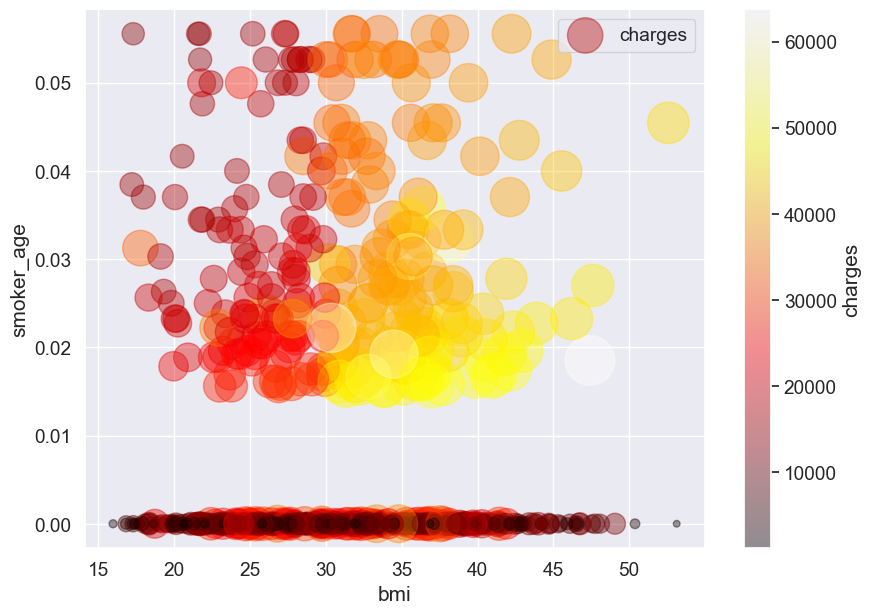

In [207]:
df.plot(kind="scatter", 
             x="bmi",
             y="smoker_age", 
             alpha=0.4,
             s=df["charges"]/50, 
             label="charges", 
             figsize=(10,7),
             c="charges", 
             cmap=plt.get_cmap("hot"), 
             colorbar=True,
             sharex=False)

* Con este scatter vemos que hay 3 categorías de coste dependiendo 2 de si fuman o no y la del medio de una variable indefinida.
*  Pienso que podríamos tener 2 datasets diferentes para cada categoría y entrenar 2 modelos diferentes.

<AxesSubplot: xlabel='age', ylabel='charges'>

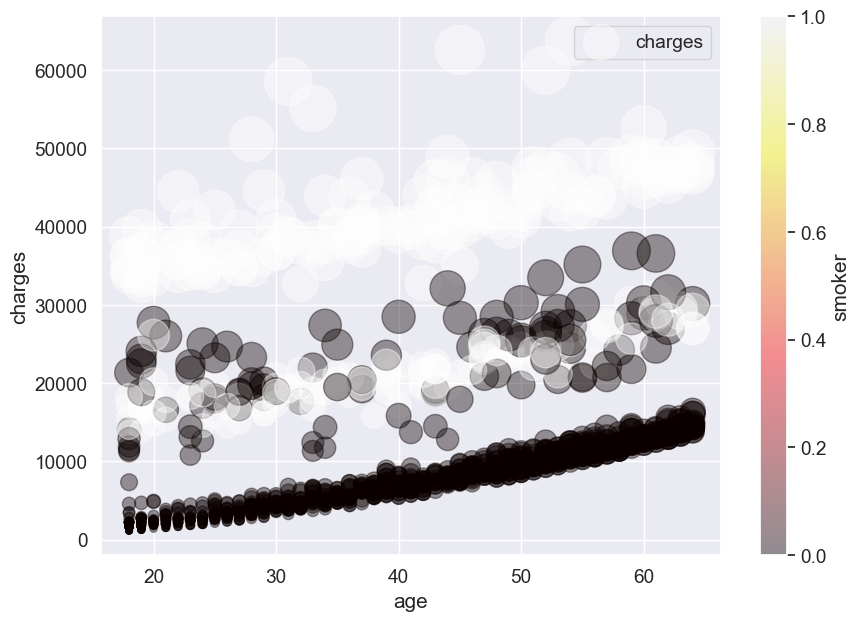

In [208]:
df.plot(kind="scatter", 
             x="age", 
             y="charges", 
             alpha=0.4,
             s=df["charges"]/50, 
             label="charges", 
             figsize=(10,7),
             c="smoker", 
             cmap=plt.get_cmap("hot"), 
             colorbar=True,
             sharex=False)

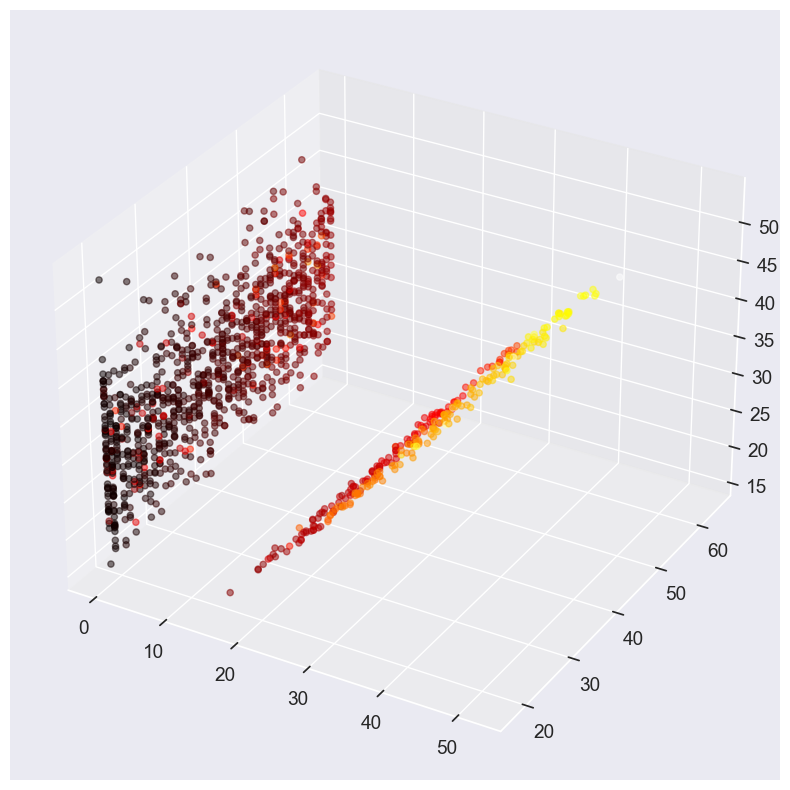

In [209]:
figura = plt.figure(figsize=(10,10))
ax = figura.add_subplot(projection='3d')

ax.scatter(df["smoker_fit"], df["age"], df["bmi"], c=df["charges"], cmap=plt.get_cmap("hot"), alpha=0.5)

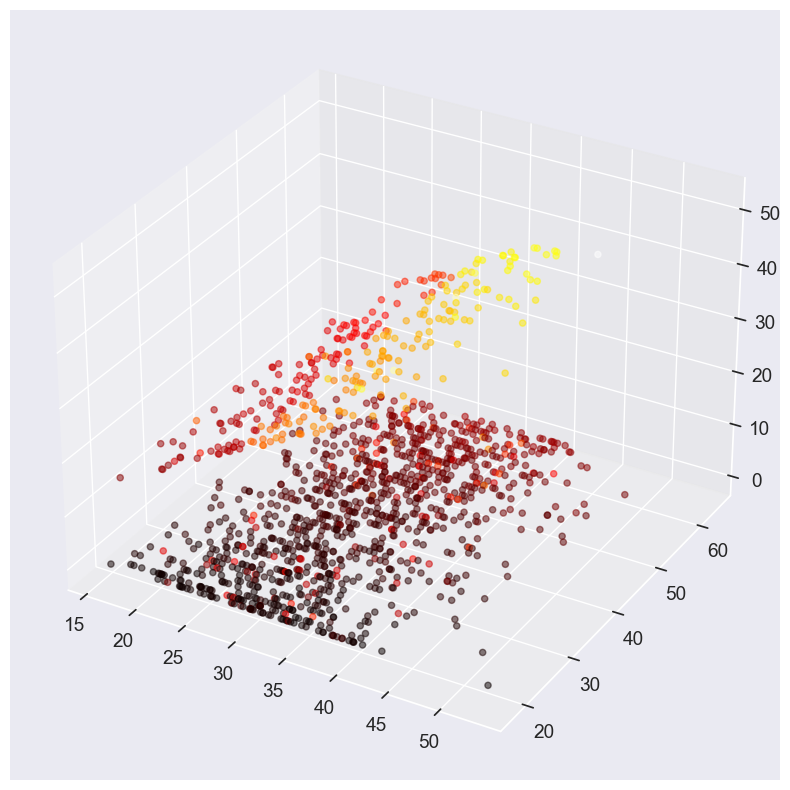

In [210]:
# Mostrar un subplot con una superficie en 3D
figura = plt.figure(figsize=(10,10))
ax = figura.add_subplot(projection='3d')

ax.scatter(df["bmi"], df["age"], df["smoker_fit"], c=df["charges"], cmap=plt.get_cmap("hot"), alpha=0.5)

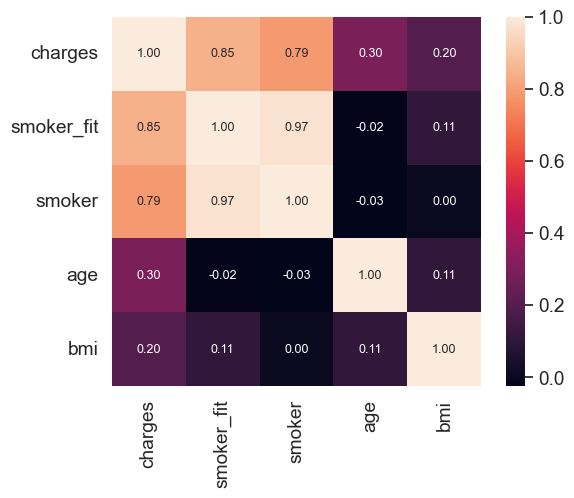

In [211]:
k = 20
# copy of the dataset
df2 = df[["smoker", "bmi", "age", "charges","smoker_fit"]]
corrmat = df2.corr()
cols = corrmat.nlargest(k, 'charges')['charges'].index
cm = np.corrcoef(df2[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 9}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

#### Datasets para entrenar

In [212]:
df_smoker_fit = df[["charges", "smoker_fit", "age"]]
df_original = df[["charges", "smoker", "bmi", "age"]]
df_fumadores = df[df["smoker"]==1]
df_fumadores = df_fumadores[["charges","bmi", "age"]]
df_no_fumadores = df[df["smoker"]==0]
df_no_fumadores = df_no_fumadores[["charges","bmi", "age"]]



In [213]:
def split_train_test(data, test_ratio):
    # https://numpy.org/doc/stable/reference/random/generated/numpy.random.permutation.html
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [214]:

smoker_fit_train, smoker_fit_test  = split_train_test(df_smoker_fit, 0.2)
original_train, original_test = split_train_test(df_original, 0.2)
fumadores_train, fumadores_test = split_train_test(df_fumadores, 0.2)
no_fumadores_train, no_fumadores_test = split_train_test(df_no_fumadores, 0.2)

In [215]:
smoker_train_y = smoker_fit_train["charges"].copy()
smoker_train_x = smoker_fit_train.drop("charges",axis=1)

In [216]:
original_y = original_train["charges"].copy()
original_x = original_train.drop("charges",axis=1)

In [217]:
fumadores_y = fumadores_train["charges"].copy()
fumadores_x = fumadores_train.drop("charges",axis=1)

In [218]:
no_fumadores_y = no_fumadores_train["charges"].copy()
no_fumadores_x = no_fumadores_train.drop("charges",axis=1)

### Modelos

#### Funcion para calcular el error

In [219]:
def calcular_rmse(y, ypred):
    ridge_mse = mean_squared_error(y, ypred)
    ridge_rmse = np.sqrt(ridge_mse)
    return ridge_rmse

#### Linear Regression

##### Predición

In [220]:
lin_reg = LinearRegression()
X_train = original_x
y_train = original_y
lin_reg.fit(X_train, y_train)

LinearRegression()

In [221]:
some_data = X_train.iloc[:5]
print("Predictions:", lin_reg.predict(some_data))

some_labels = y_train.iloc[:5]
print("Labels:", list(some_labels))

Predictions: [15942.62569643 11662.47063696  9149.39240068  7306.99016102
 25095.32600425]
Labels: [8083.9198, 8835.26495, 8026.6666, 5272.1758, 26125.67477]


##### Error

In [222]:
predictions = lin_reg.predict(X_train)
calcular_rmse(y_train, predictions)

6061.421436048614

#### Random Forest

In [223]:
# import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
predictions = rfr.predict(X_train)

In [224]:
calcular_rmse(y_train, predictions)

1995.4516110294762

#### Vector Support Machine

In [225]:
# import Vector support machine
from sklearn.svm import SVR
svr = SVR()
svr.fit(X_train, y_train)
predictions = svr.predict(X_train)

In [226]:
calcular_rmse(y_train, predictions)

12721.043873020628

#### Ridge

In [227]:
# import Ridge
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1)
ridge.fit(X_train, y_train)
predictions = ridge.predict(X_train)

In [228]:
calcular_rmse(y_train, predictions)

6061.667374624147

#### Lasso

In [229]:
# import Lasso
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
predictions = lasso.predict(X_train)

In [230]:
calcular_rmse(y_train, predictions)

6061.421441152168

### Test

In [232]:
x = original_test.drop("charges",axis=1)
y = original_test["charges"].copy()
prediction = rfr.predict(x)
calcular_rmse(y, prediction)

5501.783343456801